In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt


from sklearn import  linear_model
from sklearn.metrics import r2_score

import torch

%config Completer.use_jedi = False

%matplotlib notebook

%load_ext autoreload

%autoreload 2

In [2]:
def hm_diagonal(corr):
    nondiag_entries = corr[np.tril_indices_from(corr, k = -1)]
    return np.mean(abs(nondiag_entries))

### Import last hidden layer

In [3]:
fd = 'Biroli_MNIST/'

X = torch.load(fd+'features_fc_nlay6_512_wd0.03_bs256_ep4_seed0_test.pt').numpy()
#X = torch.load(fd+'features_fc_nlay6_512_batch_norm_wd0.01_bs256_ep5_seed0_test.pt').numpy()

# randomize indices (not really necessary)
np.random.seed(11)
indices = np.random.choice(np.arange(X.shape[0]), (10000), replace = False)

X = X[indices]
print(X.shape)

(10000, 512)


### Fit from small chunks to full representation

In [4]:
### fit on full layer from chunks

# chunk sizes
css = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

# number of repetitions
nreps = 3

# initialised matrices of residuals and covariances
rsqs = np.zeros((len(css), nreps))
diag_covs = np.zeros((len(css), 512, nreps))
covs = np.zeros((len(css), 512, 512, nreps))

for i, cs in enumerate(css):
    print(cs)

    for r in range(nreps):
    
        indices = np.random.choice(np.arange(512), (cs), replace = False)
        Xc = X[:, indices]
        
        lm = linear_model.LinearRegression()
        lm = linear_model.Ridge(1e-8)
        
        lm.fit(Xc, X)
        X_pred = lm.predict(Xc)
        
        res = (X - X_pred)
        cov = np.cov(res.T)
        diag_covs[i, :, r] = np.diag(cov)
        
        rsqs[i, r]= r2_score(X, X_pred, multioutput = 'variance_weighted')
        covs[i,:, :, r] = cov
    

1
2
4


/Users/aldoglielmo/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.95821e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


8


/Users/aldoglielmo/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.13092e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/aldoglielmo/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.53074e-11): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/aldoglielmo/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.73775e-11): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


16


/Users/aldoglielmo/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.28824e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/aldoglielmo/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.41967e-11): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


32


/Users/aldoglielmo/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.67955e-11): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/aldoglielmo/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.01883e-11): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


64
128
256
512


### Compute regolarised correlation of residuals

In [5]:
# compute regolarised correlation of residuals
reg = 1e-8
corrs = covs/(np.sqrt((diag_covs[:, :, None, :]*diag_covs[:, None, :, :]))+reg)

mean_non_diag_abs_corr = np.zeros((corrs.shape[0], corrs.shape[3]))

for i in range(corrs.shape[0]):
    for j in range(corrs.shape[3]):
        mean_non_diag_abs_corr[i, j] = hm_diagonal(corrs[i, :, :, j])
        

### Plots

<IPython.core.display.Javascript object>


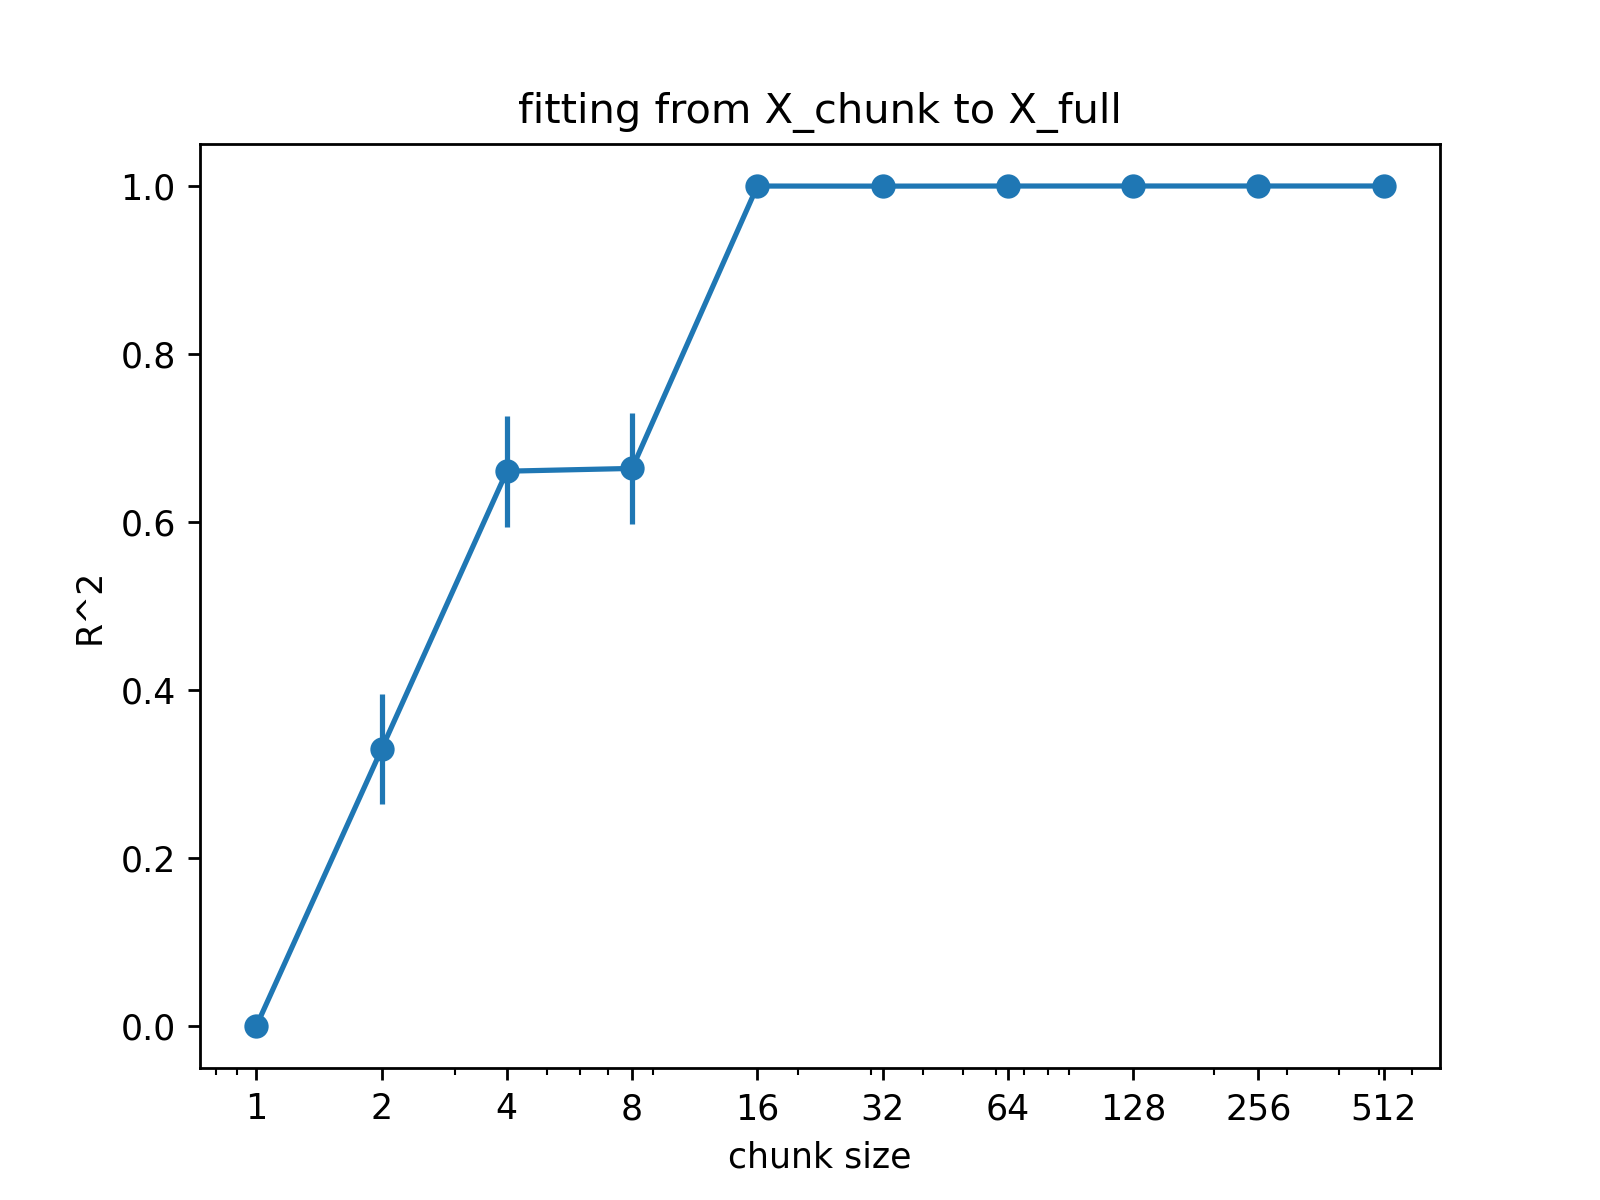

Text(0.5, 1.0, 'fitting from X_chunk to X_full')

In [11]:
# plot R^2 value
plt.figure()
plt.errorbar(css, rsqs.mean(axis = 1)
             , rsqs.std(axis = 1)/np.sqrt(50), marker = 'o');
plt.xscale('log');
plt.xticks(css, css);
plt.xlabel('chunk size')
plt.ylabel('R^2')
plt.title('fitting from X_chunk to X_full')

<IPython.core.display.Javascript object>


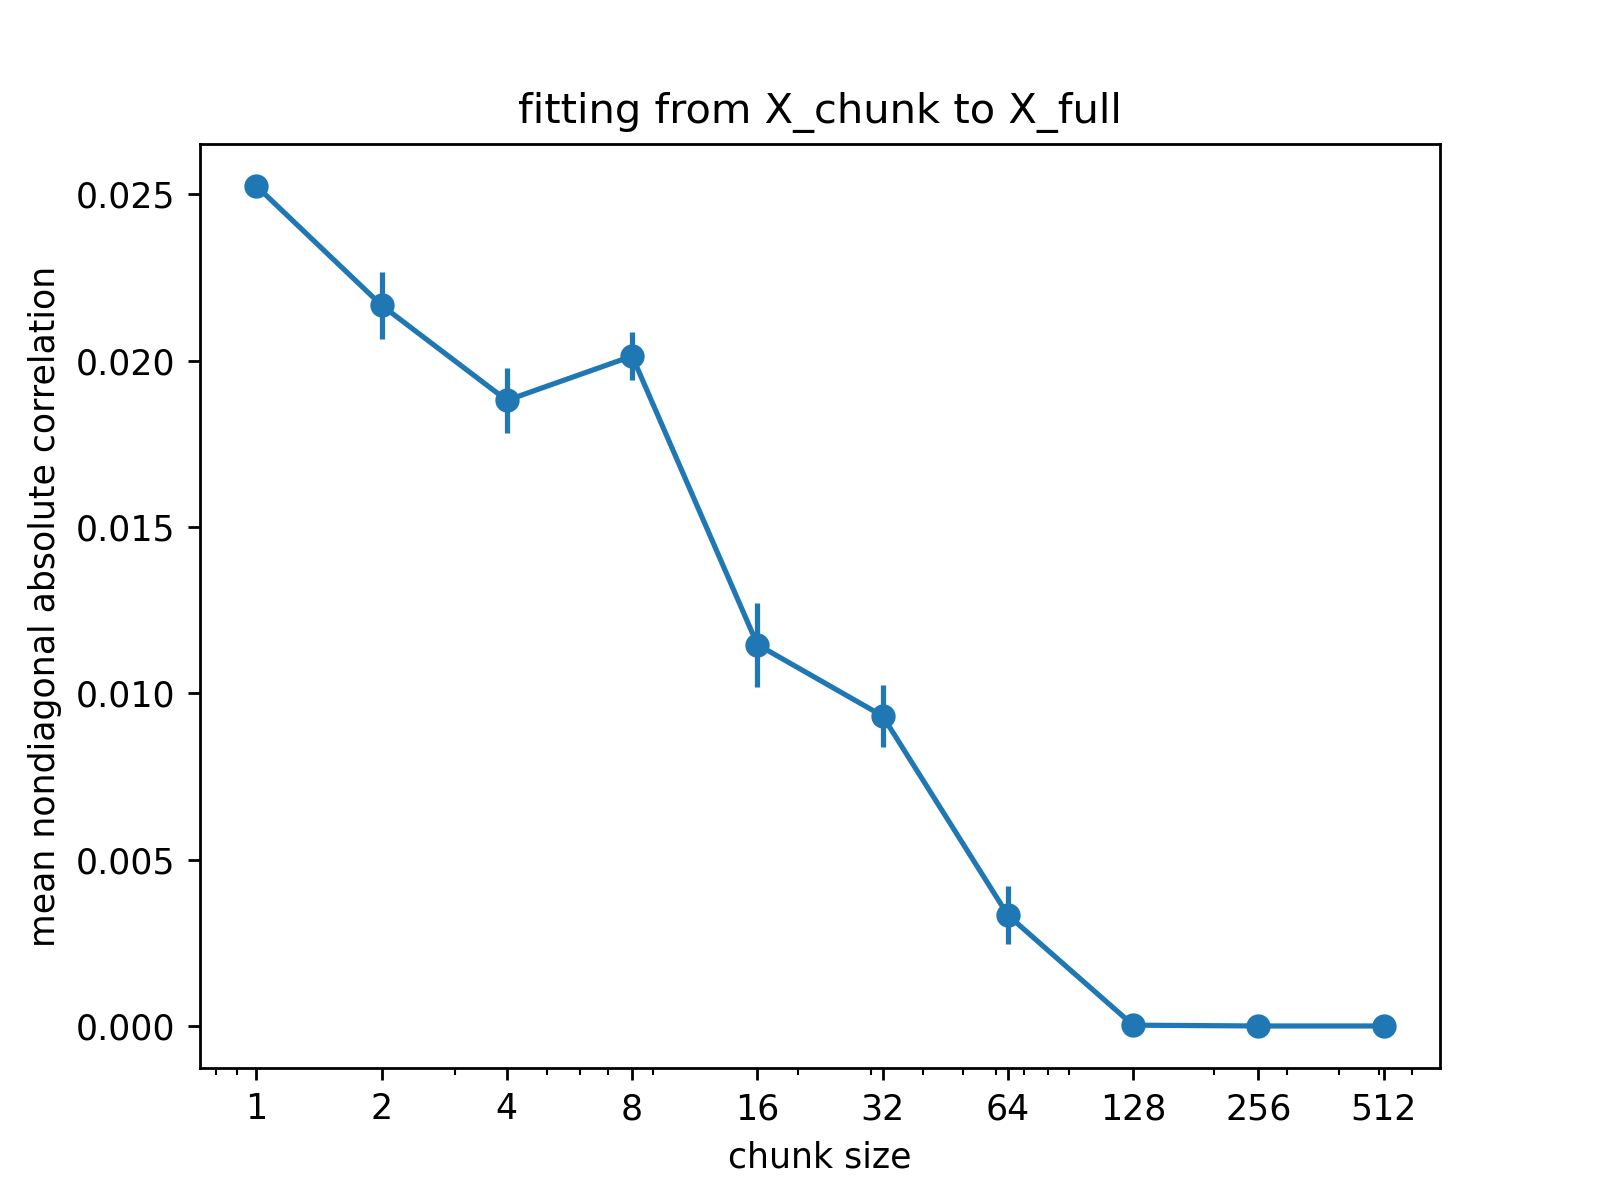

Text(0.5, 1.0, 'fitting from X_chunk to X_full')

In [12]:
# plot mean nondiagonal absolute correlation
plt.figure()
plt.errorbar(css, mean_non_diag_abs_corr.mean(axis = 1)
             , mean_non_diag_abs_corr.std(axis = 1)/np.sqrt(25), marker = 'o');
plt.xscale('log');
plt.xticks(css, css);
plt.xlabel('chunk size')
plt.ylabel('mean nondiagonal absolute correlation')
plt.title('fitting from X_chunk to X_full')